In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from models_gaussian import StandardGaussianHMM, GaussianDenseHMM
import time
from tqdm import tqdm
from ssm.util import find_permutation   # finds the best permutation to match the states
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

np.random.seed(2022)

2022-08-04 07:16:49.871858: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-04 07:16:49.871938: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
def prepare_params(n):  # Does not hold the assumption: pi stationar of A
    pi = np.random.uniform(size=n)
    pi /= pi.sum()

    A = np.exp(np.random.uniform(0, 5, size=(n, n)))
    A +=  np.diag([5 for _ in range(n)])
    A /= A.sum(axis=1)[:, np.newaxis]

    # TODO:  you can change the difficuly of an example by changing the ranges for mu and sigma
    mu = np.random.uniform(-20, 20, size=n)  # bigger range - easier task
    sigma = np.random.uniform(0.1,  1.0, size=n)  # smaller range -  easier task
    return pi, A, mu, sigma


def my_hmm_sampler(pi, A,  mu, sigma, T):  # TODO
    n = pi.shape[0]
    X = [np.random.choice(np.arange(n), 1, replace=True, p=pi)]
    for t in range(T - 1):
        X.append(np.random.choice(np.arange(n), 1, replace=True, p=A[X[t][0], :]))
    Y = np.concatenate([np.random.normal(mu[s[0]], sigma[s[0]], 1) for s in X]).reshape(-1, 1)
    return X, Y

def prepare_data(pi, A,  mu, sigma, T, s):
    data = [my_hmm_sampler(pi, A, mu, sigma, T) for _ in range(s)]
    X_true = np.concatenate([np.concatenate(y[0]) for y in data])
    Y_true = np.concatenate([x[1] for x in data])
    lengths = [len(x[1]) for x in data]
    return X_true, Y_true, lengths  # hidden states, observations, lengths of individual sequences

def dtv(a1, a2):
    return (abs(a1 - a2) / 2).sum() / a1.shape[0]

Initial distribution:  
 [0.01505084 0.80260167 0.18234749]
Transition matrix: 
 [[0.12960601 0.6349542  0.2354398 ]
 [0.427543   0.14639522 0.42606178]
 [0.21864572 0.37938259 0.40197168]]
Distributions of outputs: 
 - N(mu=13.343, sigma=0.545)
 - N(mu=18.282, sigma=0.406)
 - N(mu=-5.278, sigma=0.657)


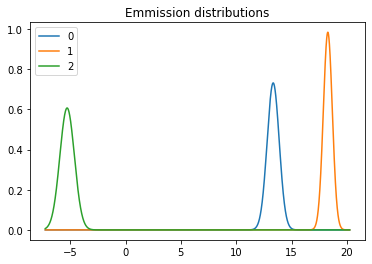

In [3]:
n = 3  # TODO:  define number of hidden states
pi, A, mu, sigma = prepare_params(n)

print("Initial distribution:  \n", pi)
print("Transition matrix: \n",  A)
print("Distributions of outputs: \n", "\n ".join([f"- N(mu={round(m, 3)}, sigma={round(sig, 3)})" for m, sig in zip(mu, sigma)]))

x = np.linspace(min(mu) - 3 * max(sigma), max(mu) + 3*max(sigma), 10000)
for i in range(n):
    plt.plot(x, stats.norm.pdf(x, mu[i], sigma[i]), label=str(i))
plt.title("Emmission distributions")
plt.legend()
plt.show()

In [4]:
s = 44  # TODO: define number of observed  sequences
T = 72  # TODO:  define length of observed seqences

X_true, Y_true, lengths = prepare_data(pi, A,  mu, sigma, T, s)

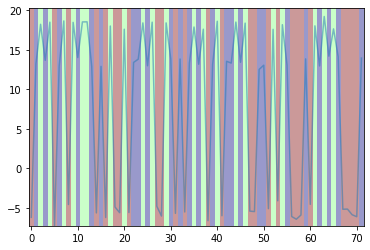

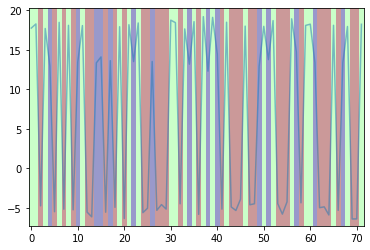

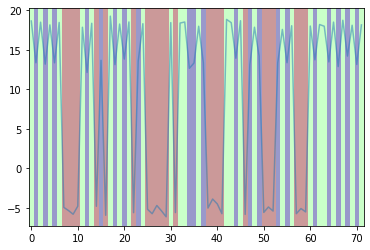

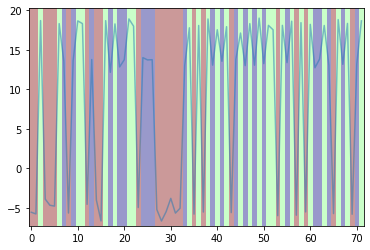

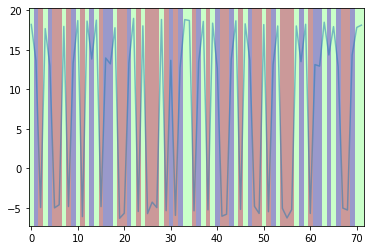

In [5]:
plot_all_sequences = False  #  Plot all  (or 5)  sequences

for i in range(s if plot_all_sequences else  5):
    i1 = sum(lengths[:i])
    i2 = sum(lengths[:(i+1)])
    plt.imshow(X_true[i1:i2].reshape(1, -1), aspect="auto", extent = (-.5, T-.5, min(mu) - 3 * max(sigma), max(mu) + 3*max(sigma)), cmap="jet", alpha=0.4)
    plt.plot(Y_true[i1:i2], alpha=.5)
    plt.show()

#  Standard HMM

In [6]:
# fit standard HMM - custom implementation

standardhmm = StandardGaussianHMM(n, em_iter=20, covariance_type='diag')

start = time.perf_counter()
standardhmm.fit(Y_true, lengths)
print("Standard HMM learning time:", round(time.perf_counter() - start, 3))

preds = np.concatenate([standardhmm.predict(Y_true[sum(lengths[:i]):sum(lengths[:(i+1)])]) for i in range(s)])
perm = find_permutation(preds, X_true)
preds_perm = np.array([perm[i] for i in preds])
print("Standard HMM accuracy: ", round((X_true == preds_perm).mean(),  3))

# TODO:  permute metrices
print("d_tv for initial probability:", round(dtv(standardhmm.startprob_.reshape(1, -1), pi[perm].reshape(1, -1)),  3))
print("d_tv for transition probability:", round(dtv(standardhmm.transmat_, A[perm, :][:, perm]),  3))
print("MAE for mus:", round(abs(mu[perm] - standardhmm.means_[:, 0]).mean(),  3))
print("MAE for sigmas:", round(abs(sigma[perm] - standardhmm.covars_[:, 0, 0]).mean(),  3))

Fit model: 100%|██████████████████████████████████| 2/2 [00:04<00:00,  2.34s/it]


Standard HMM learning time: 6.094
Standard HMM accuracy:  0.722
d_tv for initial probability: 0.394
d_tv for transition probability: 0.186
MAE for mus: 1.115
MAE for sigmas: 22.185


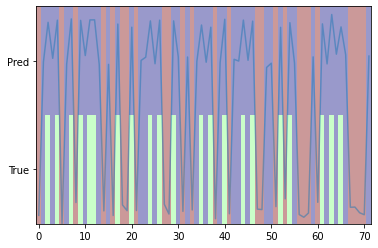

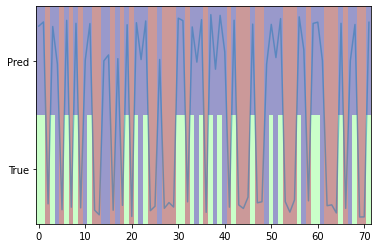

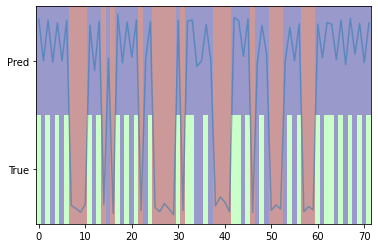

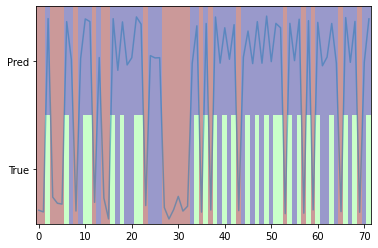

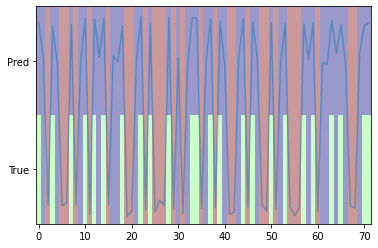

In [7]:
for i in range(s if plot_all_sequences else  5):
    i1 = sum(lengths[:i])
    i2 = sum(lengths[:(i+1)])
    lim_bottom = min(mu) - 3 * max(sigma)
    lim_semi = (min(mu) + max(mu)) / 2
    lim_upper = max(mu) + 3*max(sigma)
    plt.imshow(X_true[i1:i2].reshape(1, -1), aspect="auto", extent = (-.5, T-.5, lim_bottom, lim_semi), cmap="jet", alpha=0.4)
    plt.imshow(preds_perm[i1:i2].reshape(1, -1), aspect="auto", extent = (-.5, T-.5, lim_semi, lim_upper), cmap="jet", alpha=0.4)
    plt.yticks([(lim_bottom + lim_semi) / 2, (lim_semi + lim_upper) / 2],  ["True", "Pred"])
    plt.plot(Y_true[i1:i2], alpha=.5)
    plt.show()

# Dense HMM

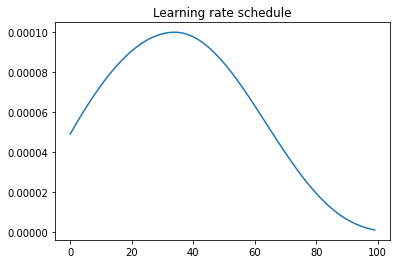

In [8]:
EM_ITER=100
def em_scheduler(max_lr, it):
    if it <= np.ceil(EM_ITER / 3):
        return max_lr * np.cos(3 * (np.ceil(EM_ITER / 3) - it) * np.pi * .33 / EM_ITER)
    else:
        return max_lr * np.cos((it - np.ceil(EM_ITER / 3)) * np.pi * .66 / EM_ITER) ** 3

plt.plot([em_scheduler(.0001, it) for it in range(EM_ITER)])
plt.title("Learning rate schedule")
plt.show()

In [9]:
# fit dense HMM - custom implementation
l_uz = 2  # TODO: specify length of the embedings

# TODO: play with mstep_config parameters
# You may like to use early stopping and specify convergence_tol
densehmm = GaussianDenseHMM(n, em_iter=20, covariance_type='diag', mstep_config={"em_lr": 0.001, "em_epochs": 15, 'l_uz': l_uz, "em_scheduler": em_scheduler},
                            early_stopping=True, convergence_tol=5e-4, init_params="", opt_schemes={"em"})

start = time.perf_counter()
densehmm.fit(Y_true, lengths)
print("Dense HMM learning time:", round(time.perf_counter() - start, 3))

preds_d = np.concatenate([densehmm.predict(Y_true[sum(lengths[:i]):sum(lengths[:(i+1)])]) for i in range(s)])
perm_d = find_permutation(preds_d, X_true)
preds_perm_d = np.array([perm_d[i] for i in preds_d])
print("Dense HMM accuracy: ", round((X_true == preds_perm_d).mean(),  3))

print("d_tv for initial probability:", round(dtv(densehmm.startprob_.reshape(1, -1), pi[perm_d].reshape(1, -1)),  3))
print("d_tv for transition probability:", round(dtv(densehmm.transmat_, A[perm_d, :][:, perm_d]),  3))
print("MAE for mus:", round(abs(mu[perm_d] - densehmm.means_[:, 0]).mean(),  3))
print("MAE for sigmas:", round(abs(sigma[perm_d] - densehmm.covars_[:, 0, 0]).mean(),  3))

# ValueError: array must not contain infs or NaNs - probably means that one state has been dropped, to be handled

2022-08-04 07:17:43.045544: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-04 07:17:43.045587: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-04 07:17:43.045621: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cymestmp): /proc/driver/nvidia/version does not exist
2022-08-04 07:17:43.061133: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-04 07:17:43.105332: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization p

Dense HMM learning time: 8.425
Dense HMM accuracy:  0.676
d_tv for initial probability: 0.598
d_tv for transition probability: 0.305
MAE for mus: 2.735
MAE for sigmas: 52.316


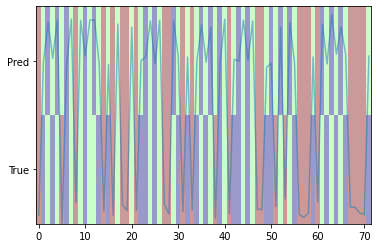

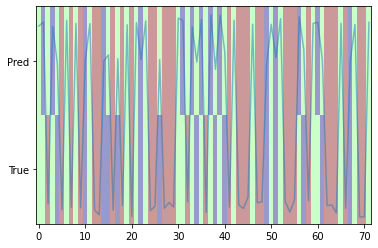

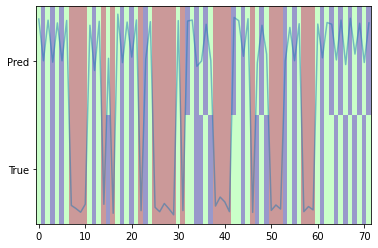

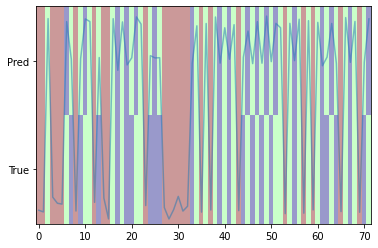

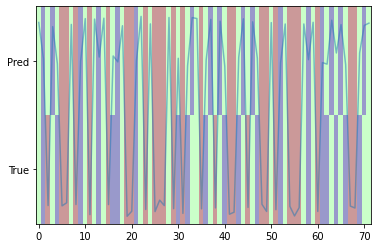

In [10]:
for i in range(s if plot_all_sequences else  5):
    i1 = sum(lengths[:i])
    i2 = sum(lengths[:(i+1)])
    lim_bottom = min(mu) - 3 * max(sigma)
    lim_semi = (min(mu) + max(mu)) / 2
    lim_upper = max(mu) + 3*max(sigma)
    plt.imshow(X_true[i1:i2].reshape(1, -1), aspect="auto", extent = (-.5, T-.5, lim_bottom, lim_semi), cmap="jet", alpha=0.4)
    plt.imshow(preds_perm_d[i1:i2].reshape(1, -1), aspect="auto", extent = (-.5, T-.5, lim_semi, lim_upper), cmap="jet", alpha=0.4)
    plt.yticks([(lim_bottom + lim_semi) / 2, (lim_semi + lim_upper) / 2],  ["True", "Pred"])
    plt.plot(Y_true[i1:i2], alpha=.5)
    plt.show()

## Dense HMM Co-occurrences

In [17]:
# fit dense HMM - custom implementation
l_uz = 4  # TODO: specify length of the embedings

# TODO: play with mstep_config parameters
# You may like to use early stopping and specify convergence_tol
densehmm = GaussianDenseHMM(n, covariance_type='diag', mstep_config={"cooc_lr": 0.001, "cooc_epochs": 10000, 'l_uz': l_uz},
                            early_stopping=True, convergence_tol=5e-4, init_params="stmc", opt_schemes={"cooc"},
                            discrete_observables=12)

start = time.perf_counter()
densehmm.fit_coocs(Y_true, lengths)
print("Dense HMM learning time:", round(time.perf_counter() - start, 3))

preds_d = np.concatenate([densehmm.predict(Y_true[sum(lengths[:i]):sum(lengths[:(i+1)])]) for i in range(s)])
perm_d = find_permutation(preds_d, X_true)
preds_perm_d = np.array([perm_d[i] for i in preds_d])
print("Dense HMM accuracy: ", round((X_true == preds_perm_d).mean(),  3))

print("d_tv for initial probability:", round(dtv(densehmm.startprob_.reshape(1, -1), pi[perm_d].reshape(1, -1)),  3))
print("d_tv for transition probability:", round(dtv(densehmm.transmat_, A[perm_d, :][:, perm_d]),  3))
print("MAE for mus:", round(abs(mu[perm_d] - densehmm.means_[:, 0]).mean(),  3))
print("MAE for sigmas:", round(abs(sigma[perm_d] - densehmm._covars_[0, 0]).mean(),  3))

Dense HMM learning time: 12.637
Dense HMM accuracy:  0.722
d_tv for initial probability: 0.813
d_tv for transition probability: 0.392
MAE for mus: 30.512
MAE for sigmas: 9.974


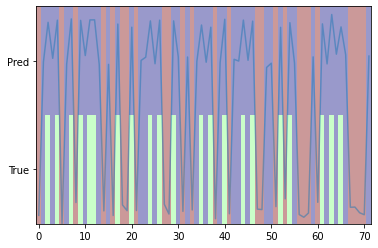

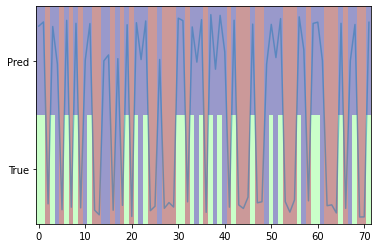

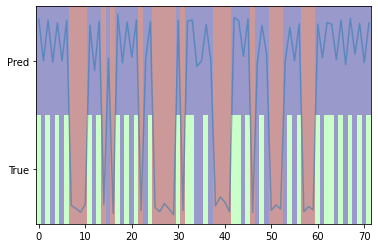

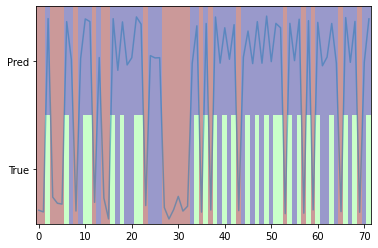

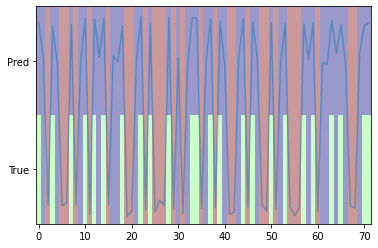

In [12]:
for i in range(s if plot_all_sequences else  5):
    i1 = sum(lengths[:i])
    i2 = sum(lengths[:(i+1)])
    lim_bottom = min(mu) - 3 * max(sigma)
    lim_semi = (min(mu) + max(mu)) / 2
    lim_upper = max(mu) + 3*max(sigma)
    plt.imshow(X_true[i1:i2].reshape(1, -1), aspect="auto", extent = (-.5, T-.5, lim_bottom, lim_semi), cmap="jet", alpha=0.4)
    plt.imshow(preds_perm_d[i1:i2].reshape(1, -1), aspect="auto", extent = (-.5, T-.5, lim_semi, lim_upper), cmap="jet", alpha=0.4)
    plt.yticks([(lim_bottom + lim_semi) / 2, (lim_semi + lim_upper) / 2],  ["True", "Pred"])
    plt.plot(Y_true[i1:i2], alpha=.5)
    plt.show()

In [18]:
np.random.seed(2022)

simple_model = {"mu": 10,
                "sigma": 1}

complicated_model = {"mu": 5,
                     "sigma": 2}

data_sizes = [(100,  400, 10)]  # (s, T, n)

ls = (2, 3, 4,  5,  8,  10)
ms = (11,  20, 50,  75, 100,  200)

# mstep_cofigs = [{"em_lr": 0.0001, "em_epochs": 10},
#                 {"em_lr": 0.0001, "em_epochs": 25},
#                 {"em_lr": 0.0001, "em_epochs": 50},
#                 {"em_lr": 0.001, "em_epochs": 10},
#                 {"em_lr": 0.001, "em_epochs": 25},
#                 {"em_lr": 0.01, "em_epochs": 5},
#                 {"em_lr": 0.01, "em_epochs": 10}]

mstep_cofigs = [{"cooc_lr": 0.00001, "cooc_epochs": 10000},
                {"cooc_lr": 0.0001, "em_epochs": 10000},
                {"cooc_lr": 0.001, "cooc_epochs": 10000},
                {"cooc_lr": 0.01, "cooc_epochs": 10000},
                {"cooc_lr": 0.1, "cooc_epochs": 10000}]

EM_ITER = 50
TOLERANCE = 1e-4

In [19]:
def prepare_params(n, simple_model=True):
    pi = np.random.uniform(size=n)
    pi /= pi.sum()
    A = np.exp(np.random.uniform(0, 5, size=(n, n)))
    A /= A.sum(axis=1)[:, np.newaxis]

    if simple_model:
        mu = np.arange(n) * 10
        sigma = np.ones(shape=n)
    else:
        mu = np.random.uniform(0, n*3, size=n)
        sigma = np.random.uniform(.5, 1.75, size=n)
    return pi, A, mu, sigma


def my_hmm_sampler(pi, A,  mu, sigma, T):
    n = pi.shape[0]
    X = [np.random.choice(np.arange(n), 1, replace=True, p=pi)]
    for t in range(T - 1):
        X.append(np.random.choice(np.arange(n), 1, replace=True, p=A[X[t][0], :]))
    Y = np.concatenate([np.random.normal(mu[s[0]], sigma[s[0]], 1) for s in X]).reshape(-1, 1)
    return X, Y


def provide_log_info(pi, A, mu, sigma, X_true, model,  time_tmp, perm, preds_perm, mstep_cofig=None, embeddings=None):
    return [dict(time=time_tmp,
                 acc=(X_true == preds_perm).mean(),
                 d_tv_A=dtv(model.transmat_, A[perm, :][:, perm]),
                 d_tv_pi=dtv(model.startprob_.reshape(1, -1), pi[perm].reshape(1, -1)),
                 MAE_mu=abs(mu[perm] - model.means_[:, 0]).mean(),
                 MAE_sigma=abs(sigma[perm] - model.covars_[:, 0, 0]).mean(),
                 mu_est=model.means_.tolist(),
                 sigma_est=model.covars_.tolist(),
                 A_est=model.transmat_.tolist(),
                 pi_est=model.startprob_.tolist(),
                 preds=preds_perm.tolist(),
                 mstep_cofig=mstep_cofig,
                 embeddings=permute_embeddings(embeddings, perm))]


def init_model(model, A_init, pi_init, m_init, c_init):
    model.transmat_ = A_init
    model.startprob_ = pi_init
    model.means_ = m_init
    model._covars_ = c_init


def predict_permute(model, data, X_true):
    preds = np.concatenate([model.predict(x[1]) for x in data])
    perm = find_permutation(preds, X_true)
    return np.array([perm[i] for i in preds]), perm


def em_scheduler(max_lr, it):
    if it <= np.ceil(EM_ITER / 3):
        return max_lr * np.cos(3 * (np.ceil(EM_ITER / 3) - it) * np.pi * .33 / EM_ITER)
    else:
        return max_lr * np.cos((it - np.ceil(EM_ITER / 3)) * np.pi * .66 / EM_ITER) ** 3


def init_experiment(dsize, simple_model):
    s = dsize[0]
    T = dsize[1]
    n = dsize[2]
    pi, A, mu, sigma = prepare_params(n, simple_model)

    data = [my_hmm_sampler(pi, A, mu, sigma, T) for _ in range(s)]
    X_true = np.concatenate([np.concatenate(y[0]) for y in data])  # states
    Y_true = np.concatenate([x[1] for x in data])  # observations
    lengths = [len(x[1]) for x in data]

    result = {
        "number_of_sequences": s,
        "sequence_length": T,
        "number_of_hidden_states": n,
        "pi": pi.tolist(),
        "A": A.tolist(),
        "mu": mu.tolist(),
        "sigma": sigma.tolist(),
        "simple_model": simple_model,
        "data": [X_true.tolist(), Y_true.tolist(), lengths],
        "hmmlearn_runs": [],
        "standard_gaussian_runs": [],
        "gaussian_dense_runs": []
    }

    true_values = {
        "states": X_true,
        "transmat": A,
        "startprob": pi,
        "means": mu,
        "covars": sigma
    }

    # wandb_params = {
    #     "init": {
    #         "project": "gaussian-dense-hmm",
    #         "entity": "cirglaboratory",
    #         "save_code": True,
    #         "group": f"benchmark-{t.tm_year}-{t.tm_mon}-{t.tm_mday}-test",  # v2
    #         "job_type": f"n={n}-s={s}-T={T}-simple={simple_model}",
    #         "name": f"PDFs",
    #         "reinit": True
    #     },
    #     "config": {
    #         "n": n,
    #         "s": s,
    #         "T": T,
    #         "model": None
    #     }
    # }
    #
    # wandb.init(**wandb_params["init"], config=wandb_params["config"])
    #
    # x = np.linspace(min(mu) - 3 * max(sigma), max(mu) + 3 * max(sigma), 10000)
    # for i in range(n):
    #     plt.plot(x, stats.norm.pdf(x, mu[i], sigma[i]), label=str(i))
    # plt.title(f"Normal PDFs n={n}-s={s}-T={T}-simple={simple_model}")
    # wandb.log({"Normal densities": wandb.Image(plt)})
    # plt.close()
    #
    # plt.plot([em_scheduler(1, it) for it in range(EM_ITER)])
    # plt.title("Learning rate schedule")
    # wandb.log({"LR schedule": wandb.Image(plt)})
    # plt.close()
    wandb_params = None
    return s, T, n, pi, A, mu, sigma, result, true_values, wandb_params, X_true, Y_true, lengths, data

In [20]:
dsize = data_sizes[0]
s, T, n, pi, A, mu, sigma, result, true_values, wandb_params, X_true, Y_true, lengths, data = init_experiment(dsize, simple_model)

for mstep_cofig, l,  m in itertools.product(mstep_cofigs, ls, ms):

    densehmm = GaussianDenseHMM(n, mstep_config={**mstep_cofig, "l_uz": l, "em_scheduler": em_scheduler},
                                covariance_type='diag', em_iter=EM_ITER,
                                init_params="", params="stmc", early_stopping=False, opt_schemes={"cooc"},
                                discrete_observables=m)
    # init_model(densehmm, A_init, pi_init, m_init, c_init)

    start = time.perf_counter()
    densehmm.fit_coocs(Y_true, lengths)
    time_tmp = time.perf_counter() - start

    preds_perm, perm = predict_permute(densehmm, data, X_true)

    result['dense_cooc_runs'] += provide_log_info(pi, A, mu, sigma, X_true,
                                                densehmm, time_tmp, perm, preds_perm,
                                                {**mstep_cofig, "l_uz": l},
                                                embeddings=densehmm.get_representations())

ValueError: Dimension 0 in both shapes must be equal, but are 10 and 3. Shapes are [10] and [3]. for '{{node concat_4}} = ConcatV2[N=3, T=DT_DOUBLE, Tidx=DT_INT32](concat_4/values_0, mul, concat_4/values_2, concat_4/axis)' with input shapes: [1,3], [10,10], [1,3], [] and with computed input tensors: input[3] = <0>.

In [26]:
sigma.reshape(-1, 1).reshape(-1).shape

(10,)

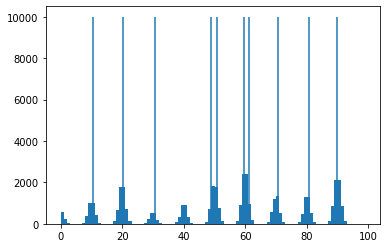

In [47]:
plt.hist(Y_true, bins=[i for i in range(100)])
plt.vlines(densehmm.discrete_nodes, np.zeros(densehmm.discrete_nodes.shape), np.ones(densehmm.discrete_nodes.shape)*10000)